In [4]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pandas as pd

In [122]:
def memory(alphas, p=0.5):
    v = []
    m = []
    for i, a in enumerate(alphas):
        m.append(p ** (len(alphas) - i - 1))
        v.append(m[-1] * a)
    v = torch.sum(torch.stack(v), dim=0) / sum(m)
    return v

def cache_memory(alpha, mem, p=0.5):
    return (alpha + p * mem) / (1 + p)

def alpha_loss(alpha, y_hats):
    one_m = torch.ones(y_hats.shape[1])
    loss = 0.5 * (alpha @ one_m).T @ (alpha @ one_m) - \
        torch.trace(alpha @ y_hats.T)
    return loss

def opt_alpha(y_hats, max_iters=1_000, lr=0.0001, quiet=True, round_lr=False): # n x m
    alpha = torch.zeros_like(y_hats)
    lrs = np.exp(np.linspace(np.log(0.1), np.log(lr), max_iters))
    for i in (pbar := tqdm(range(max_iters), position=0, leave=True, disable=quiet)):
        alpha = torch.maximum(torch.zeros_like(alpha), alpha).detach()
        alpha.requires_grad_(True)
        optimizer = torch.optim.Adam([alpha], lr=lrs[i])
        optimizer.zero_grad()
        loss = alpha_loss(alpha, y_hats)
        pbar.set_description(f'Loss: {loss:.2f}/Max: {torch.max(alpha):.2f}')
        loss.backward()
        optimizer.step()
    if round_lr:
        alpha = torch.round(alpha, decimals=int(1 - np.log10(lr)))
    alpha = torch.maximum(torch.zeros_like(alpha), alpha).detach()
    return alpha

In [10]:
# Load data & fix
df = pd.read_csv('../datasets/data_banknote_authentication.txt', header=None)
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
y = y * 2 - 1

In [45]:
idx_pos = np.where(y == 1)[0]
idx_neg = np.where(y == -1)[0]

In [12]:
# Doublecheck fit
svm = sklearn.svm.SVC(kernel='rbf')
svm.fit(X, y=y)
svm.score(X, y=y), svm.score(X[y==-1.0], y[y==-1.0]), svm.score(X[y==1.0], y[y==1.0])

(1.0, 1.0, 1.0)

# Step By Step

In [90]:
# Try initializing with a +&- random point having 1 utility
m = 2
n, d = X.shape
models = [sklearn.svm.SVC(C=1e10, kernel='rbf') for _ in range(m)]
for j in range(m):
    i_pos = idx_pos[np.random.randint(len(idx_pos))]
    i_neg = idx_neg[np.random.randint(len(idx_neg))]
    models[j].fit(X[[i_pos, i_neg]], y=[1, -1])
# Collect scores
y_hats = []
for j in range(m):
    y_hats.append(models[j].decision_function(X))
y_hats = torch.tensor(np.stack(y_hats).T, dtype=torch.float)
M = np.zeros_like(y_hats)

In [105]:
# Optimize alpha
alpha = opt_alpha(y_hats, quiet=False)
print([torch.sum(alpha.T[j]).item() / n for j in range(m)])

Loss: -1474.36/Max: 4.21: 100%|███████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.70it/s]

[0.29760255062892904, 0.6147700718470982]


In [106]:
# Update memory
M = cache_memory(alpha=alpha, mem=M, p=0.5)

In [107]:
# Train new models
models = [sklearn.svm.SVC(C=1e10, kernel='rbf').fit(X, y=y, sample_weight=M.T[j]) for j in range(m)]
print([models[j].score(X, y=y, sample_weight=M.T[j]) for j in range(m)])

[1.0, 1.0]


In [108]:
# Collect new scores
y_hats = []
for j in range(m):
    y_hats.append(models[j].decision_function(X))
y_hats = torch.tensor(np.stack(y_hats).T, dtype=torch.float)

In [113]:
print([torch.sum(M.T[j]).item() / n for j in range(m)])

[0.2725437709263393, 0.5530320326023824]


# All At Once

In [123]:
# Initialization 

m = 2
epochs = 5
n, d = X.shape
models = [sklearn.svm.SVC(C=1e10, kernel='rbf') for _ in range(m)]
for j in range(m):
    i_pos = idx_pos[np.random.randint(len(idx_pos))]
    i_neg = idx_neg[np.random.randint(len(idx_neg))]
    models[j].fit(X[[i_pos, i_neg]], y=[1, -1])
# Collect scores
y_hats = []
for j in range(m):
    y_hats.append(models[j].decision_function(X))
y_hats = torch.tensor(np.stack(y_hats).T, dtype=torch.float)
M = np.zeros_like(y_hats)

# Setup End-Of-Run Stats

y_hats_eor = []
alphas_eor = []
Ms_eor = []
models_eor = []

# Iterable

for e in range(epochs):
    y_hats_eor.append(y_hats)
    # Optimize alpha
    alpha = opt_alpha(y_hats, quiet=False, round_lr=True)
    alphas_eor.append(alpha)
    # Update memory
    M = cache_memory(alpha=alpha, mem=M, p=0.5)
    Ms_eor.append(M)
    # Train new models
    models = [sklearn.svm.SVC(C=1e10, kernel='rbf').fit(X, y=y, sample_weight=M.T[j]) for j in range(m)]
    models_eor.append(models)
    # Collect new scores
    y_hats = []
    for j in range(m):
        y_hats.append(models[j].decision_function(X))
    y_hats = torch.tensor(np.stack(y_hats).T, dtype=torch.float)

Loss: -1492.90/Max: 4.20: 100%|███████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.28it/s]


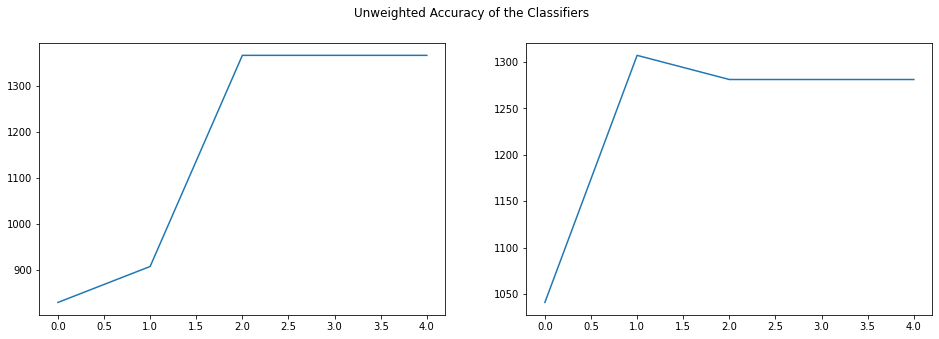

In [136]:
fig, ax = plt.subplots(1, m, figsize=(16,5))
fig.suptitle('Unweighted Accuracy of the Classifiers')
for j in range(m):
    ax[j].plot(range(epochs), [sum([1 if yh > 0 else -1 for yh in yhs.T[j]] == y) for yhs in y_hats_eor])

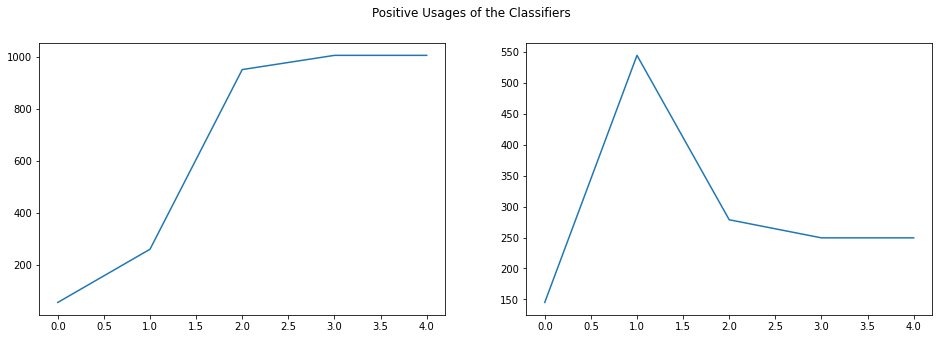

In [137]:
fig, ax = plt.subplots(1, m, figsize=(16,5))
fig.suptitle('Positive Usages of the Classifiers')
for j in range(m):
    ax[j].plot(range(epochs), [torch.sum(a.T[j][idx_pos]) for a in alphas_eor])

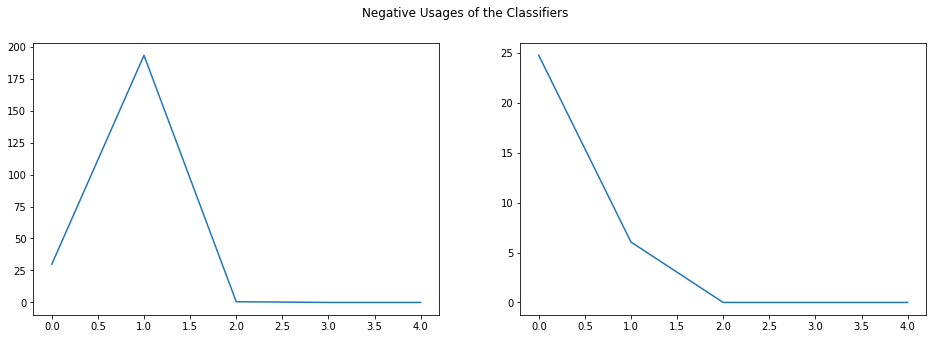

In [138]:
fig, ax = plt.subplots(1, m, figsize=(16,5))
fig.suptitle('Negative Usages of the Classifiers')
for j in range(m):
    ax[j].plot(range(epochs), [torch.sum(a.T[j][idx_neg]) for a in alphas_eor])

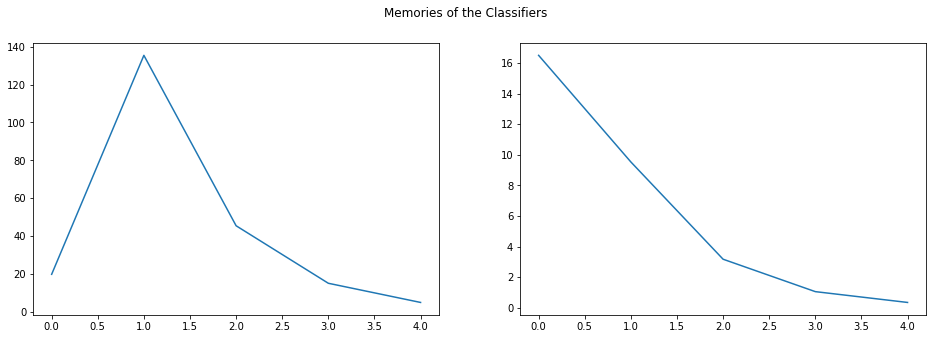

In [139]:
fig, ax = plt.subplots(1, m, figsize=(16,5))
fig.suptitle('Memories of the Classifiers')
for j in range(m):
    ax[j].plot(range(epochs), [torch.sum(mem.T[j][idx_neg]) for mem in Ms_eor])